# Testing with new data (MVP Com. Valenciana)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import datetime as dt
from tools import dataoveriew, plot_roc_curve, plot_confusion_matrix
from datetime import datetime
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, plot_precision_recall_curve
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import pickle

pd.options.display.max_columns = None

class_names = ['Activo','Baja']

%matplotlib inline

In [2]:
data = pd.read_excel('../data/test_feb21.xlsx')
data.head()

,Installation Date,Installation Number,Client Type,Panel,Territorial,Provincia,Zip,Gender,Nationality,Country Of Birth,Born Date,Housing Type,Labor Situation,Marital Status,Income Amount,Number Pay,Price List,Monitoring Status Date,Monitoring Status,Tipo Instalacion,Financiado,Rango Kit,Resumen Precio,Kit Contado,Kit Total,Kit Mensualidad,Quejas,MT
0,2021-02-02,3807436,Normal,SDVFSW,Este,Murcia,30380,H - HOMBRE,ES - ESPAÑOLA,ARGENTINA,1958-10-06,1 - PROPIEDAD SIN HIPOTECA,07 PENSIONISTA (JUBILACION),2 - CASADO,1200,12,HBD,2021-02-02,OP,P-Apartamento (domicilio particular),Financiado,Mas de 300,699+(36*10),699,1059,10,NaN,NaN
1,2021-02-02,3807468,Normal,SDVFSW,Este,Valencia,46100,H - HOMBRE,ES - ESPAÑOLA,SPAIN,1974-01-29,3 - ALQUILER,04 AUTONOMO,2 - CASADO,1400,14,EEE,2021-02-02,OP,N-Tienda- negocio al publico,Financiado,Entre 000-050,49+(48*10),49,529,10,NaN,NaN
2,2021-02-02,3807509,Normal,SDVFSW,Este,Murcia,30006,H - HOMBRE,ES - ESPAÑOLA,SPAIN,1947-02-02,1 - PROPIEDAD SIN HIPOTECA,07 PENSIONISTA (JUBILACION),2 - CASADO,1500,14,HBD,2021-02-02,OP,P-Chalet adosado,Financiado,Entre 100-200,199+(36*10),199,559,10,NaN,NaN
3,2021-02-02,3807515,Normal,SDVFSW,Noreste,Barcelona,8100,H - HOMBRE,AF - AFRICA MENOS MAGREB,SPAIN,1963-02-02,3 - ALQUILER,01 ASALARIADO FIJO,2 - CASADO,1500,14,HBD,2021-02-04,OP,P-Apartamento (domicilio particular),Financiado,Entre 050-100,99+(36*10),99,459,10,NaN,NaN
4,2021-02-02,3807516,Gran_Cuenta,SDVFSW,Centro-Noroeste,Madrid Noroeste,28341,H - HOMBRE,ES - ESPAÑOLA,SPAIN,1965-02-11,1 - PROPIEDAD SIN HIPOTECA,04 AUTONOMO,2 - CASADO,1200,12,AED,2021-04-08,XPRU,P-Apartamento (domicilio particular),Financiado,A 0,0+(36*10),0,360,10,1.0,8.0


In [3]:
data.shape

(12183, 28)

In [4]:
data.isnull().sum()

Installation Date             0
Installation Number           0
Client Type                   0
Panel                         0
Territorial                   0
Provincia                     0
Zip                           0
Gender                        0
Nationality                   0
Country Of Birth              0
Born Date                    84
Housing Type                  0
Labor Situation               0
Marital Status                0
Income Amount                 0
Number Pay                    0
Price List                    0
Monitoring Status Date        0
Monitoring Status             0
Tipo Instalacion              0
Financiado                    0
Rango Kit                     0
Resumen Precio                0
Kit Contado                   0
Kit Total                     0
Kit Mensualidad               0
Quejas                    11801
MT                        10840
dtype: int64

In [5]:
data['Monitoring Status'] = data['Monitoring Status'].replace({'XPRU': 'BAJA', 'XCAN': 'BAJA', 'XVEN': 'BAJA'})
data['Quejas'] = data['Quejas'].replace(np.nan, 0).astype('int')
data['MT'] = data['MT'].replace(np.nan, 0).astype('int')
data['Installation Number'] = data['Installation Number'].astype('str')
data['Zip'] = data['Zip'].astype('str')
data['Monitoring Status'] = data['Monitoring Status'].astype('str').str.strip()
data['Monitoring Status'] = data['Monitoring Status'].replace({'OP': 0, 'BAJA': 1}).astype(int)
data.head()

,Installation Date,Installation Number,Client Type,Panel,Territorial,Provincia,Zip,Gender,Nationality,Country Of Birth,Born Date,Housing Type,Labor Situation,Marital Status,Income Amount,Number Pay,Price List,Monitoring Status Date,Monitoring Status,Tipo Instalacion,Financiado,Rango Kit,Resumen Precio,Kit Contado,Kit Total,Kit Mensualidad,Quejas,MT
0,2021-02-02,3807436,Normal,SDVFSW,Este,Murcia,30380,H - HOMBRE,ES - ESPAÑOLA,ARGENTINA,1958-10-06,1 - PROPIEDAD SIN HIPOTECA,07 PENSIONISTA (JUBILACION),2 - CASADO,1200,12,HBD,2021-02-02,0,P-Apartamento (domicilio particular),Financiado,Mas de 300,699+(36*10),699,1059,10,0,0
1,2021-02-02,3807468,Normal,SDVFSW,Este,Valencia,46100,H - HOMBRE,ES - ESPAÑOLA,SPAIN,1974-01-29,3 - ALQUILER,04 AUTONOMO,2 - CASADO,1400,14,EEE,2021-02-02,0,N-Tienda- negocio al publico,Financiado,Entre 000-050,49+(48*10),49,529,10,0,0
2,2021-02-02,3807509,Normal,SDVFSW,Este,Murcia,30006,H - HOMBRE,ES - ESPAÑOLA,SPAIN,1947-02-02,1 - PROPIEDAD SIN HIPOTECA,07 PENSIONISTA (JUBILACION),2 - CASADO,1500,14,HBD,2021-02-02,0,P-Chalet adosado,Financiado,Entre 100-200,199+(36*10),199,559,10,0,0
3,2021-02-02,3807515,Normal,SDVFSW,Noreste,Barcelona,8100,H - HOMBRE,AF - AFRICA MENOS MAGREB,SPAIN,1963-02-02,3 - ALQUILER,01 ASALARIADO FIJO,2 - CASADO,1500,14,HBD,2021-02-04,0,P-Apartamento (domicilio particular),Financiado,Entre 050-100,99+(36*10),99,459,10,0,0
4,2021-02-02,3807516,Gran_Cuenta,SDVFSW,Centro-Noroeste,Madrid Noroeste,28341,H - HOMBRE,ES - ESPAÑOLA,SPAIN,1965-02-11,1 - PROPIEDAD SIN HIPOTECA,04 AUTONOMO,2 - CASADO,1200,12,AED,2021-04-08,1,P-Apartamento (domicilio particular),Financiado,A 0,0+(36*10),0,360,10,1,8


In [6]:
provincias = ['Alicante', 'Valencia', 'Castellon']

data_filtered = data[data['Provincia'].isin(provincias)]
data_filtered.head()

,Installation Date,Installation Number,Client Type,Panel,Territorial,Provincia,Zip,Gender,Nationality,Country Of Birth,Born Date,Housing Type,Labor Situation,Marital Status,Income Amount,Number Pay,Price List,Monitoring Status Date,Monitoring Status,Tipo Instalacion,Financiado,Rango Kit,Resumen Precio,Kit Contado,Kit Total,Kit Mensualidad,Quejas,MT
1,2021-02-02,3807468,Normal,SDVFSW,Este,Valencia,46100,H - HOMBRE,ES - ESPAÑOLA,SPAIN,1974-01-29,3 - ALQUILER,04 AUTONOMO,2 - CASADO,1400,14,EEE,2021-02-02,0,N-Tienda- negocio al publico,Financiado,Entre 000-050,49+(48*10),49,529,10,0,0
18,2021-02-02,3807628,Normal,SDVFSW,Este,Valencia,46160,H - HOMBRE,ES - ESPAÑOLA,SPAIN,1950-04-03,1 - PROPIEDAD SIN HIPOTECA,07 PENSIONISTA (JUBILACION),2 - CASADO,1000,12,HBD,2021-02-02,0,"P-Chalet, villa (domicilio particular)",Financiado,Entre 000-050,49+(36*10),49,409,10,0,0
20,2021-02-02,3807632,Normal,SDVFAST,Este,Alicante,3189,M - MUJER,UE - UNION EUROPEA,BRITISH INDIAN OCEAN TERRITORY,1933-06-18,1 - PROPIEDAD SIN HIPOTECA,07 PENSIONISTA (JUBILACION),3 - VIUDO,1000,12,HBD,2021-02-02,0,P-Chalet Pareado,Financiado,Entre 200-300,299+(36*10),299,659,10,0,0
26,2021-02-02,3807669,Normal,SDVFSW,Este,Valencia,46183,H - HOMBRE,ES - ESPAÑOLA,SPAIN,1961-03-28,1 - PROPIEDAD SIN HIPOTECA,01 ASALARIADO FIJO,2 - CASADO,1500,14,HBD,2021-02-02,0,P-Apartamento (domicilio particular),Financiado,Entre 100-200,199+(36*10),199,559,10,0,0
29,2021-02-02,3807692,Normal,SDVFSW,Este,Alicante,3150,H - HOMBRE,ES - ESPAÑOLA,SPAIN,1988-08-28,1 - PROPIEDAD SIN HIPOTECA,01 ASALARIADO FIJO,1 - SOLTERO,1300,14,HBD,2021-02-03,0,P-Apartamento (domicilio particular),Financiado,Entre 000-050,49+(36*10),49,409,10,0,0


In [7]:
data_filtered.shape

(1363, 28)

In [8]:
data_filtered.to_excel('../data/test_com_valencia.xlsx')

In [9]:
data = pd.read_excel('../data/test_com_valencia.xlsx')
data.drop(['Unnamed: 0'],axis=1,inplace=True)
data.head()

,Installation Date,Installation Number,Client Type,Panel,Territorial,Provincia,Zip,Gender,Nationality,Country Of Birth,Born Date,Housing Type,Labor Situation,Marital Status,Income Amount,Number Pay,Price List,Monitoring Status Date,Monitoring Status,Tipo Instalacion,Financiado,Rango Kit,Resumen Precio,Kit Contado,Kit Total,Kit Mensualidad,Quejas,MT
0,2021-02-02,3807468,Normal,SDVFSW,Este,Valencia,46100,H - HOMBRE,ES - ESPAÑOLA,SPAIN,1974-01-29,3 - ALQUILER,04 AUTONOMO,2 - CASADO,1400,14,EEE,2021-02-02,0,N-Tienda- negocio al publico,Financiado,Entre 000-050,49+(48*10),49,529,10,0,0
1,2021-02-02,3807628,Normal,SDVFSW,Este,Valencia,46160,H - HOMBRE,ES - ESPAÑOLA,SPAIN,1950-04-03,1 - PROPIEDAD SIN HIPOTECA,07 PENSIONISTA (JUBILACION),2 - CASADO,1000,12,HBD,2021-02-02,0,"P-Chalet, villa (domicilio particular)",Financiado,Entre 000-050,49+(36*10),49,409,10,0,0
2,2021-02-02,3807632,Normal,SDVFAST,Este,Alicante,3189,M - MUJER,UE - UNION EUROPEA,BRITISH INDIAN OCEAN TERRITORY,1933-06-18,1 - PROPIEDAD SIN HIPOTECA,07 PENSIONISTA (JUBILACION),3 - VIUDO,1000,12,HBD,2021-02-02,0,P-Chalet Pareado,Financiado,Entre 200-300,299+(36*10),299,659,10,0,0
3,2021-02-02,3807669,Normal,SDVFSW,Este,Valencia,46183,H - HOMBRE,ES - ESPAÑOLA,SPAIN,1961-03-28,1 - PROPIEDAD SIN HIPOTECA,01 ASALARIADO FIJO,2 - CASADO,1500,14,HBD,2021-02-02,0,P-Apartamento (domicilio particular),Financiado,Entre 100-200,199+(36*10),199,559,10,0,0
4,2021-02-02,3807692,Normal,SDVFSW,Este,Alicante,3150,H - HOMBRE,ES - ESPAÑOLA,SPAIN,1988-08-28,1 - PROPIEDAD SIN HIPOTECA,01 ASALARIADO FIJO,1 - SOLTERO,1300,14,HBD,2021-02-03,0,P-Apartamento (domicilio particular),Financiado,Entre 000-050,49+(36*10),49,409,10,0,0


In [10]:
data['Born Date'].isnull().sum()

8

In [11]:
data['Born Date'] = data['Born Date'].replace(np.nan, datetime(1970, 1, 1))

In [12]:
data['Born Date'].isnull().sum()

0

In [13]:
data['Edad'] = 0
fecha = datetime(2021, 4, 18)

for i in range(len(data['Born Date'])):
    if data.loc[i, 'Monitoring Status'] == 0:
        data.loc[i,'Edad'] = ((fecha - data.loc[i,'Born Date']).days)/365
    else:
        data.loc[i,'Edad'] = ((data.loc[i,'Monitoring Status Date'] - data.loc[i,'Born Date']).days)/365
                        
data.head()

,Installation Date,Installation Number,Client Type,Panel,Territorial,Provincia,Zip,Gender,Nationality,Country Of Birth,Born Date,Housing Type,Labor Situation,Marital Status,Income Amount,Number Pay,Price List,Monitoring Status Date,Monitoring Status,Tipo Instalacion,Financiado,Rango Kit,Resumen Precio,Kit Contado,Kit Total,Kit Mensualidad,Quejas,MT,Edad
0,2021-02-02,3807468,Normal,SDVFSW,Este,Valencia,46100,H - HOMBRE,ES - ESPAÑOLA,SPAIN,1974-01-29,3 - ALQUILER,04 AUTONOMO,2 - CASADO,1400,14,EEE,2021-02-02,0,N-Tienda- negocio al publico,Financiado,Entre 000-050,49+(48*10),49,529,10,0,0,47.249315
1,2021-02-02,3807628,Normal,SDVFSW,Este,Valencia,46160,H - HOMBRE,ES - ESPAÑOLA,SPAIN,1950-04-03,1 - PROPIEDAD SIN HIPOTECA,07 PENSIONISTA (JUBILACION),2 - CASADO,1000,12,HBD,2021-02-02,0,"P-Chalet, villa (domicilio particular)",Financiado,Entre 000-050,49+(36*10),49,409,10,0,0,71.090411
2,2021-02-02,3807632,Normal,SDVFAST,Este,Alicante,3189,M - MUJER,UE - UNION EUROPEA,BRITISH INDIAN OCEAN TERRITORY,1933-06-18,1 - PROPIEDAD SIN HIPOTECA,07 PENSIONISTA (JUBILACION),3 - VIUDO,1000,12,HBD,2021-02-02,0,P-Chalet Pareado,Financiado,Entre 200-300,299+(36*10),299,659,10,0,0,87.893151
3,2021-02-02,3807669,Normal,SDVFSW,Este,Valencia,46183,H - HOMBRE,ES - ESPAÑOLA,SPAIN,1961-03-28,1 - PROPIEDAD SIN HIPOTECA,01 ASALARIADO FIJO,2 - CASADO,1500,14,HBD,2021-02-02,0,P-Apartamento (domicilio particular),Financiado,Entre 100-200,199+(36*10),199,559,10,0,0,60.098630
4,2021-02-02,3807692,Normal,SDVFSW,Este,Alicante,3150,H - HOMBRE,ES - ESPAÑOLA,SPAIN,1988-08-28,1 - PROPIEDAD SIN HIPOTECA,01 ASALARIADO FIJO,1 - SOLTERO,1300,14,HBD,2021-02-03,0,P-Apartamento (domicilio particular),Financiado,Entre 000-050,49+(36*10),49,409,10,0,0,32.660274


In [14]:
for i in range(len(data['Edad'])):
    if data.loc[i, 'Edad'] < 18:
        data.loc[i, 'Edad'] = data['Edad'].mean()
    else:
        continue

In [15]:
# Mapping Edad 
data.loc[data['Edad'] <= 30, 'Rango_Edad'] = "18-30"
data.loc[(data['Edad'] > 30) & (data['Edad'] <= 40), 'Rango_Edad'] = "30-40"
data.loc[(data['Edad'] > 40) & (data['Edad'] <= 50), 'Rango_Edad'] = "40-50"
data.loc[(data['Edad'] > 50) & (data['Edad'] <= 60), 'Rango_Edad'] = "50-60"
data.loc[(data['Edad'] > 60) & (data['Edad'] <= 70), 'Rango_Edad'] = "60-70"
data.loc[(data['Edad'] > 70) & (data['Edad'] <= 80), 'Rango_Edad'] = "70-80"
data.loc[data['Edad'] > 80, 'Rango_Edad'] = "+80"
data.head()

,Installation Date,Installation Number,Client Type,Panel,Territorial,Provincia,Zip,Gender,Nationality,Country Of Birth,Born Date,Housing Type,Labor Situation,Marital Status,Income Amount,Number Pay,Price List,Monitoring Status Date,Monitoring Status,Tipo Instalacion,Financiado,Rango Kit,Resumen Precio,Kit Contado,Kit Total,Kit Mensualidad,Quejas,MT,Edad,Rango_Edad
0,2021-02-02,3807468,Normal,SDVFSW,Este,Valencia,46100,H - HOMBRE,ES - ESPAÑOLA,SPAIN,1974-01-29,3 - ALQUILER,04 AUTONOMO,2 - CASADO,1400,14,EEE,2021-02-02,0,N-Tienda- negocio al publico,Financiado,Entre 000-050,49+(48*10),49,529,10,0,0,47.249315,40-50
1,2021-02-02,3807628,Normal,SDVFSW,Este,Valencia,46160,H - HOMBRE,ES - ESPAÑOLA,SPAIN,1950-04-03,1 - PROPIEDAD SIN HIPOTECA,07 PENSIONISTA (JUBILACION),2 - CASADO,1000,12,HBD,2021-02-02,0,"P-Chalet, villa (domicilio particular)",Financiado,Entre 000-050,49+(36*10),49,409,10,0,0,71.090411,70-80
2,2021-02-02,3807632,Normal,SDVFAST,Este,Alicante,3189,M - MUJER,UE - UNION EUROPEA,BRITISH INDIAN OCEAN TERRITORY,1933-06-18,1 - PROPIEDAD SIN HIPOTECA,07 PENSIONISTA (JUBILACION),3 - VIUDO,1000,12,HBD,2021-02-02,0,P-Chalet Pareado,Financiado,Entre 200-300,299+(36*10),299,659,10,0,0,87.893151,+80
3,2021-02-02,3807669,Normal,SDVFSW,Este,Valencia,46183,H - HOMBRE,ES - ESPAÑOLA,SPAIN,1961-03-28,1 - PROPIEDAD SIN HIPOTECA,01 ASALARIADO FIJO,2 - CASADO,1500,14,HBD,2021-02-02,0,P-Apartamento (domicilio particular),Financiado,Entre 100-200,199+(36*10),199,559,10,0,0,60.098630,60-70
4,2021-02-02,3807692,Normal,SDVFSW,Este,Alicante,3150,H - HOMBRE,ES - ESPAÑOLA,SPAIN,1988-08-28,1 - PROPIEDAD SIN HIPOTECA,01 ASALARIADO FIJO,1 - SOLTERO,1300,14,HBD,2021-02-03,0,P-Apartamento (domicilio particular),Financiado,Entre 000-050,49+(36*10),49,409,10,0,0,32.660274,30-40


In [16]:
# Mapping Income Amount
data.loc[data['Income Amount'] <= 1000, 'Income'] = "0-1000"
data.loc[(data['Income Amount'] > 1000) & (data['Income Amount'] <= 1500), 'Income'] = "1000-1500"
data.loc[(data['Income Amount'] > 1500) & (data['Income Amount'] <= 2000), 'Income'] = "1500-2000"
data.loc[(data['Income Amount'] > 2000) & (data['Income Amount'] <= 3000), 'Income'] = "2000-3000"
data.loc[data['Income Amount'] > 3000, 'Income'] = "+3000"
data.head()

,Installation Date,Installation Number,Client Type,Panel,Territorial,Provincia,Zip,Gender,Nationality,Country Of Birth,Born Date,Housing Type,Labor Situation,Marital Status,Income Amount,Number Pay,Price List,Monitoring Status Date,Monitoring Status,Tipo Instalacion,Financiado,Rango Kit,Resumen Precio,Kit Contado,Kit Total,Kit Mensualidad,Quejas,MT,Edad,Rango_Edad,Income
0,2021-02-02,3807468,Normal,SDVFSW,Este,Valencia,46100,H - HOMBRE,ES - ESPAÑOLA,SPAIN,1974-01-29,3 - ALQUILER,04 AUTONOMO,2 - CASADO,1400,14,EEE,2021-02-02,0,N-Tienda- negocio al publico,Financiado,Entre 000-050,49+(48*10),49,529,10,0,0,47.249315,40-50,1000-1500
1,2021-02-02,3807628,Normal,SDVFSW,Este,Valencia,46160,H - HOMBRE,ES - ESPAÑOLA,SPAIN,1950-04-03,1 - PROPIEDAD SIN HIPOTECA,07 PENSIONISTA (JUBILACION),2 - CASADO,1000,12,HBD,2021-02-02,0,"P-Chalet, villa (domicilio particular)",Financiado,Entre 000-050,49+(36*10),49,409,10,0,0,71.090411,70-80,0-1000
2,2021-02-02,3807632,Normal,SDVFAST,Este,Alicante,3189,M - MUJER,UE - UNION EUROPEA,BRITISH INDIAN OCEAN TERRITORY,1933-06-18,1 - PROPIEDAD SIN HIPOTECA,07 PENSIONISTA (JUBILACION),3 - VIUDO,1000,12,HBD,2021-02-02,0,P-Chalet Pareado,Financiado,Entre 200-300,299+(36*10),299,659,10,0,0,87.893151,+80,0-1000
3,2021-02-02,3807669,Normal,SDVFSW,Este,Valencia,46183,H - HOMBRE,ES - ESPAÑOLA,SPAIN,1961-03-28,1 - PROPIEDAD SIN HIPOTECA,01 ASALARIADO FIJO,2 - CASADO,1500,14,HBD,2021-02-02,0,P-Apartamento (domicilio particular),Financiado,Entre 100-200,199+(36*10),199,559,10,0,0,60.098630,60-70,1000-1500
4,2021-02-02,3807692,Normal,SDVFSW,Este,Alicante,3150,H - HOMBRE,ES - ESPAÑOLA,SPAIN,1988-08-28,1 - PROPIEDAD SIN HIPOTECA,01 ASALARIADO FIJO,1 - SOLTERO,1300,14,HBD,2021-02-03,0,P-Apartamento (domicilio particular),Financiado,Entre 000-050,49+(36*10),49,409,10,0,0,32.660274,30-40,1000-1500


In [17]:
# Días hasta el 19/01/2021 si OP y hasta cuando se dio de baja si BAJA

data['Dias_Activo'] = 0
fecha = datetime(2021, 4, 18)

for i in range(len(data['Installation Date'])):
    if data.loc[i, 'Monitoring Status'] == 0:
        data.loc[i,'Dias_Activo'] = (fecha - data.loc[i,'Installation Date']).days
    else:
        data.loc[i,'Dias_Activo'] = (data.loc[i,'Monitoring Status Date'] - data.loc[i,'Installation Date']).days
                        
data.head()

,Installation Date,Installation Number,Client Type,Panel,Territorial,Provincia,Zip,Gender,Nationality,Country Of Birth,Born Date,Housing Type,Labor Situation,Marital Status,Income Amount,Number Pay,Price List,Monitoring Status Date,Monitoring Status,Tipo Instalacion,Financiado,Rango Kit,Resumen Precio,Kit Contado,Kit Total,Kit Mensualidad,Quejas,MT,Edad,Rango_Edad,Income,Dias_Activo
0,2021-02-02,3807468,Normal,SDVFSW,Este,Valencia,46100,H - HOMBRE,ES - ESPAÑOLA,SPAIN,1974-01-29,3 - ALQUILER,04 AUTONOMO,2 - CASADO,1400,14,EEE,2021-02-02,0,N-Tienda- negocio al publico,Financiado,Entre 000-050,49+(48*10),49,529,10,0,0,47.249315,40-50,1000-1500,75
1,2021-02-02,3807628,Normal,SDVFSW,Este,Valencia,46160,H - HOMBRE,ES - ESPAÑOLA,SPAIN,1950-04-03,1 - PROPIEDAD SIN HIPOTECA,07 PENSIONISTA (JUBILACION),2 - CASADO,1000,12,HBD,2021-02-02,0,"P-Chalet, villa (domicilio particular)",Financiado,Entre 000-050,49+(36*10),49,409,10,0,0,71.090411,70-80,0-1000,75
2,2021-02-02,3807632,Normal,SDVFAST,Este,Alicante,3189,M - MUJER,UE - UNION EUROPEA,BRITISH INDIAN OCEAN TERRITORY,1933-06-18,1 - PROPIEDAD SIN HIPOTECA,07 PENSIONISTA (JUBILACION),3 - VIUDO,1000,12,HBD,2021-02-02,0,P-Chalet Pareado,Financiado,Entre 200-300,299+(36*10),299,659,10,0,0,87.893151,+80,0-1000,75
3,2021-02-02,3807669,Normal,SDVFSW,Este,Valencia,46183,H - HOMBRE,ES - ESPAÑOLA,SPAIN,1961-03-28,1 - PROPIEDAD SIN HIPOTECA,01 ASALARIADO FIJO,2 - CASADO,1500,14,HBD,2021-02-02,0,P-Apartamento (domicilio particular),Financiado,Entre 100-200,199+(36*10),199,559,10,0,0,60.098630,60-70,1000-1500,75
4,2021-02-02,3807692,Normal,SDVFSW,Este,Alicante,3150,H - HOMBRE,ES - ESPAÑOLA,SPAIN,1988-08-28,1 - PROPIEDAD SIN HIPOTECA,01 ASALARIADO FIJO,1 - SOLTERO,1300,14,HBD,2021-02-03,0,P-Apartamento (domicilio particular),Financiado,Entre 000-050,49+(36*10),49,409,10,0,0,32.660274,30-40,1000-1500,75


Transformaciones con `.pkl`

In [18]:
filename = '../mvp_pkl/dias_activo_sca.pkl'
scaler = pickle.load(open(filename, 'rb'))
data['Dias_Activo_sca'] = scaler.transform(data['Dias_Activo'].values.reshape(-1, 1))
# data['Dias_Activo_sca'] = data['Dias_Activo'].apply(lambda x: scaler.transform(x.values.reshape(-1, 1)))

In [19]:
filename = '../mvp_pkl/quejas_sca.pkl'
scaler = pickle.load(open(filename, 'rb'))
data['Quejas_sca'] = scaler.transform(data['Quejas'].values.reshape(-1, 1))

In [20]:
filename = '../mvp_pkl/mt_sca.pkl'
scaler = pickle.load(open(filename, 'rb'))
data['MT_sca'] = scaler.fit_transform(data['MT'].values.reshape(-1, 1))

In [21]:
data_filtered = data[['Gender', 'Housing Type', 'Tipo Instalacion', 'Labor Situation', 'Marital Status', 'Zip',
                      'Provincia', 'Nationality', 'Rango_Edad', 'Income', 'Rango Kit', 'Number Pay', 'Dias_Activo_sca',
                      'Quejas_sca', 'MT_sca', 'Monitoring Status']]
data_filtered.columns

Index(['Gender', 'Housing Type', 'Tipo Instalacion', 'Labor Situation',
       'Marital Status', 'Zip', 'Provincia', 'Nationality', 'Rango_Edad',
       'Income', 'Rango Kit', 'Number Pay', 'Dias_Activo_sca', 'Quejas_sca',
       'MT_sca', 'Monitoring Status'],
      dtype='object')

In [22]:
X = data_filtered.drop(['Monitoring Status'],axis=1)
y = data_filtered['Monitoring Status']

In [23]:
X.columns

Index(['Gender', 'Housing Type', 'Tipo Instalacion', 'Labor Situation',
       'Marital Status', 'Zip', 'Provincia', 'Nationality', 'Rango_Edad',
       'Income', 'Rango Kit', 'Number Pay', 'Dias_Activo_sca', 'Quejas_sca',
       'MT_sca'],
      dtype='object')

In [24]:
filename = '../mvp_pkl/TE_encoder.pkl'
TE_encoder = pickle.load(open(filename, 'rb'))
X = TE_encoder.transform(X)

In [25]:
X.head()

,Gender,Housing Type,Tipo Instalacion,Labor Situation,Marital Status,Zip,Provincia,Nationality,Rango_Edad,Income,Rango Kit,Number Pay,Dias_Activo_sca,Quejas_sca,MT_sca
0,0.254037,0.505832,0.472750,0.340043,0.218265,0.25876,0.273009,0.257225,0.317454,0.257014,0.329687,0.231701,0.033259,0.0,0.0
1,0.254037,0.229933,0.207563,0.144030,0.218265,0.25876,0.273009,0.257225,0.127708,0.310933,0.329687,0.284631,0.033259,0.0,0.0
2,0.276589,0.229933,0.168200,0.144030,0.182944,0.25876,0.219859,0.248352,0.168635,0.310933,0.190055,0.284631,0.033259,0.0,0.0
3,0.254037,0.229933,0.211469,0.221639,0.218265,0.25876,0.273009,0.257225,0.150680,0.257014,0.184017,0.231701,0.033259,0.0,0.0
4,0.254037,0.229933,0.211469,0.221639,0.373304,0.25876,0.219859,0.257225,0.419096,0.257014,0.329687,0.231701,0.033259,0.0,0.0


### Predicciones con modelos en `.pkl`

Random Forest Classifier:

              precision    recall  f1-score   support

           0       1.00      0.92      0.96      1359
           1       0.03      0.75      0.05         4

    accuracy                           0.92      1363
   macro avg       0.51      0.83      0.50      1363
weighted avg       1.00      0.92      0.95      1363



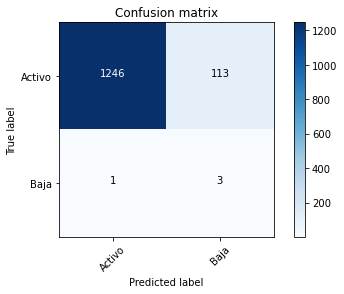

In [26]:
filename = '../mvp_pkl/rfc_model.pkl'
rfc = pickle.load(open(filename, 'rb'))

y_pred = rfc.predict(X)
print(classification_report(y, y_pred ))

cm = confusion_matrix(y, y_pred)
plot_confusion_matrix(cm, classes=class_names, title='Confusion matrix')

In [27]:
rfc.predict_proba(X)[:, 1]

array([0.34312379, 0.25133175, 0.11116524, ..., 0.60657526, 0.41390685,
       0.09580244])

Regresión Logística:

              precision    recall  f1-score   support

           0       1.00      0.57      0.73      1359
           1       0.01      1.00      0.01         4

    accuracy                           0.58      1363
   macro avg       0.50      0.79      0.37      1363
weighted avg       1.00      0.58      0.73      1363



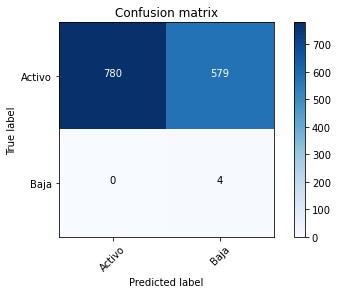

In [28]:
filename = '../mvp_pkl/LR_model.pkl'
LR = pickle.load(open(filename, 'rb'))

y_pred = LR.predict(X)
print(classification_report(y, y_pred ))

cm = confusion_matrix(y, y_pred)
plot_confusion_matrix(cm, classes=class_names, title='Confusion matrix')

Decission Tree Classifier:

              precision    recall  f1-score   support

           0       1.00      0.67      0.80      1359
           1       0.01      1.00      0.02         4

    accuracy                           0.67      1363
   macro avg       0.50      0.83      0.41      1363
weighted avg       1.00      0.67      0.80      1363



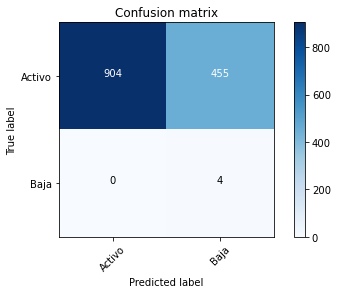

In [29]:
filename = '../mvp_pkl/DT_model.pkl'
DT = pickle.load(open(filename, 'rb'))

y_pred = DT.predict(X)
print(classification_report(y, y_pred ))

cm = confusion_matrix(y, y_pred)
plot_confusion_matrix(cm, classes=class_names, title='Confusion matrix')